<a href="https://colab.research.google.com/github/KoNGoL/tfm_breast_cancer_detection/blob/main/Pruebas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install pydicom
%pip install opencv-python
%pip install pillow # optional 
%pip install pandas 
%pip install pypng 

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
#imports
import matplotlib.pyplot as plt
import pydicom as dicom
import os
# from google.colab.patches import cv2_imshow as cv2
import cv2 as cv2
import PIL # optional
import numpy as np
import png
from operator import itemgetter
from skimage import util


In [3]:
#initialize variables
in_path = "/home/fundamentia/python/corpus/pruebas/Calc-Test_P_00038_LEFT_CC/08-29-2017-DDSM-NA-96009/1.000000-full mammogram images-63992/"
out_path = "/home/fundamentia/python/tfm_breast_cancer_detection/pruebas/procesadas/"
name = "1-1.dcm"
out_name = name + ".png"

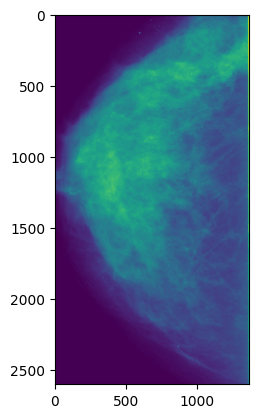

In [2]:
#convertir diccom a png
def convert_diccom_to_png(in_file, out_path):
  ds = dicom.dcmread(os.path.join(in_file))
  pixel_array_numpy = ds.pixel_array
  cv2.imwrite(os.path.join(out_path), pixel_array_numpy)

# image_path = in_path + "man2_mask2.dcm"
def show_diccom_img(diccom_path):
  ds = dicom.dcmread(diccom_path)
  plt.imshow(ds.pixel_array)
  plt.show()


# convert_diccom_to_png(in_path + name, out_path + out_name)
show_diccom_img("/home/fundamentia/python/corpus/manifest-ZkhPvrLo5216730872708713142/CBIS-DDSM/Calc-Training_P_00814_RIGHT_CC_1/09-06-2017-DDSM-NA-65401/1.000000-ROI mask images-60753/1-1.dcm")

(4616, 3016, 3)
48 4568 30 2986


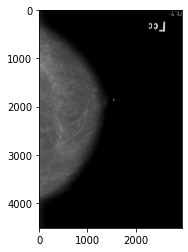

In [18]:
# recortar imagen
image_path = out_path + name + ".png"
def crop_img(image_path, output_path, x = 1, y = 4):
    img = cv2.imread(image_path)
    print(img.shape)
    # calculamos el % que se desea borrar
    y_start = int(img.shape[0]/(100-y))
    y_end = img.shape[0] - y_start
    x_start = int(img.shape[1]/(100-x))
    x_end = img.shape[1] - x_start
    print(y_start, y_end, x_start, x_end)
    # recortamos la imagen
    crop_img = img[y_start:y_end, x_start:x_end]
    plt.imshow(crop_img)
    cv2.imwrite(os.path.join(output_path), crop_img)

out_crop_path = out_path + name + "_recortdada.png"
crop_img(image_path, out_crop_path)

In [25]:
# reescalar imagen con black  background a 1024x1024
def rescale_img(image_path, output_path):
    # creamos una imagen negra de 1024x1024
    img_black = np.zeros((1024, 1024, 3))
    # leemos las dos imagenses y las reescalamos
    img_object = cv2.imread(image_path)
    img_object = cv2.resize(img_object, (768, 1024))
    # posicionamos la imagen en la parte izquierda de la imagen negra
    x = 0
    y = 0
    x_end = x + img_object.shape[0]
    y_end = y + img_object.shape[1]
    img_black[x:x_end,y:y_end] = img_object
    # guardamos la imagen
    plt.imshow(img_black)
    cv2.imwrite(os.path.join(output_path), img_black)

out_rescale_path = out_path + name + "_rescaled.png"
rescale_img(out_crop_path, out_rescale_path)

error: OpenCV(4.5.5) :-1: error: (-5:Bad argument) in function 'resize'
> Overload resolution failed:
>  - Can't parse 'dsize'. Expected sequence length 2, got 3
>  - Can't parse 'dsize'. Expected sequence length 2, got 3


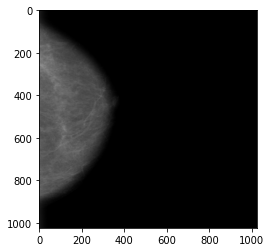

In [20]:
# eliminamos el ruido de la imagen (anotaciones de los medicos o manchas)
def remove_noise(image_path, output_path):
    img = cv2.imread(image_path)

    # normalizamos la imagen
    norm = util.img_as_ubyte((img - img.min()) / (img.max() - img.min()))
    gray = cv2.cvtColor(norm, cv2.COLOR_RGB2GRAY)

    # generamos los cortornos de la imagen
    contours, _ = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # escogemos el area de mayor tamaño
    max_area = max(contours, key=cv2.contourArea)
    
    # generamos una mascara con el area de mayor tamaño
    mask = np.zeros_like(img)
    cv2.drawContours(mask, [max_area], 0, (255, 255, 255), -1)

    # eliminamos el ruido de la imagen
    breast_img = cv2.bitwise_and(img, mask)
    
    # mostramos la imagen y la guardamos
    plt.imshow(breast_img)
    cv2.imwrite(os.path.join(output_path), breast_img)

input_image = out_path + name + "_rescaled.png"
output_noise_image = out_path + name + "_noise_removed.png"
remove_noise(input_image, output_noise_image)


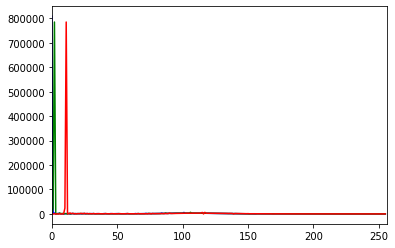

In [21]:
# CLAHE (contrast limited adaptive histogram equalization)
def clahe(image_path, output_path, clip=2.0, tile=(5,5)):
    img = cv2.imread(image_path)
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    lab_planes = list(cv2.split(lab))
    clahe = cv2.createCLAHE(clipLimit=clip, tileGridSize=tile)
    lab_planes[0] = clahe.apply(lab_planes[0])
    lab_planes[1] = clahe.apply(lab_planes[1])
    lab_planes[2] = clahe.apply(lab_planes[2])
    lab = cv2.merge(lab_planes)
    img = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    # plt.imshow(img)
    cv2.imwrite(os.path.join(output_path), img)
    color = ('b','g','r')
    for i,col in enumerate(color):
        histr, _ = np.histogram(img[:,:,i],256,[0,256])
        plt.plot(histr,color = col)
        plt.xlim([0,256])
    plt.show()

input_image = out_path + name + "_noise_removed.png"
output_clahe_image = out_path + name + "_clahe.png"
clahe(input_image, output_clahe_image)

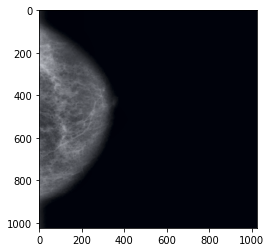

In [24]:
#morphological erosion
def morphological_erosion(image_path, output_path, kernel_size=5):
    img = cv2.imread(image_path)
    kernel = np.ones((kernel_size,kernel_size),np.uint8)
    erosion = cv2.erode(img,kernel,iterations = 1)
    plt.imshow(erosion)
    cv2.imwrite(os.path.join(output_path), erosion)

input_image = out_path + name + "_clahe.png"
output_clahe_image = out_path + name + "_erosion.png"
morphological_erosion(input_image, output_clahe_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


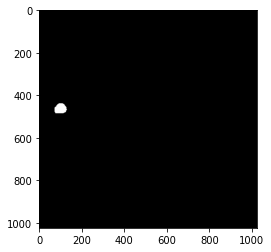

In [23]:
def process_macro(input_image, out_path):
    img = cv2.imread(input_image)
    rescale_img(input_image, out_path)

process_macro("/home/fundamentia/python/tfm_breast_cancer_detection/pruebas/1-2_macro.dcm.png", "/home/fundamentia/python/tfm_breast_cancer_detection/pruebas/1-2_macro_rescaled.dcm.png")

In [9]:
# ejemplo de detectar bounding box
def detect_bounding_box(image_path):
    #  cargamos la imagen
    img = cv2.imread(image_path)
    # detectamos los contornos de la imagen
    norm = util.img_as_ubyte((img - img.min()) / (img.max() - img.min()))
    gray = cv2.cvtColor(norm, cv2.COLOR_RGB2GRAY)
    contours,_ = cv2.findContours(gray, 1, 1) # not copying here will throw an error
    # print(contours)
    # detectamos el area de la masa
    max_area = max(contours, key=cv2.contourArea)
    rect = cv2.minAreaRect(max_area)
    # calculamos sus puntos
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    print(box)
    # max_x = max(box, key=itemgetter(1))[0]  
    # min_x = min(box, key=itemgetter(1))[0]
    # max_y = max(box, key=itemgetter(1))[1]
    # min_y = min(box, key=itemgetter(1))[1]
    max_x = [max(i) for i in zip(*box)][0]   
    min_x = [min(i) for i in zip(*box)][0] 
    max_y = [max(i) for i in zip(*box)][1] 
    min_y = [min(i) for i in zip(*box)][1] 
    print(max_x, min_x, max_y, min_y)


mask_in_path = "/home/fundamentia/python/corpus/transformadas/mascaras/Mass-Training_P_02033_RIGHT_MLO_1.png"
detect_bounding_box(mask_in_path)


[[361 791]
 [419 754]
 [453 808]
 [395 845]]
453 361 845 754
